<a href="https://colab.research.google.com/github/Kisponis/VAE-VQ-VAE/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Здесь я в учебных целях разработал VAE и VQ-VAE


Сначала определим 2 класса для VQ-VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = commitment_cost

        self.embeddings = nn.Parameter(torch.randn(num_embeddings, embedding_dim))

    def forward(self, z_e):
        # z_e: (B, D, H, W)
        z_e_flat = z_e.permute(0, 2, 3, 1).contiguous()   # (B, H, W, D)
        z_e_flat = z_e_flat.view(-1, self.embedding_dim)  # (BHW, D)


        distances = (
            torch.sum(z_e_flat**2, dim=1, keepdim=True)
            - 2 * torch.matmul(z_e_flat, self.embeddings.t())
            + torch.sum(self.embeddings**2, dim=1)
        )  # (BHW, num_embeddings)

        encoding_indices = torch.argmin(distances, dim=1)  # (BHW,)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).type(z_e.dtype)


        quantized = torch.matmul(encodings, self.embeddings)  # (BHW, D)
        quantized = quantized.view(z_e.shape[0], z_e.shape[2], z_e.shape[3], self.embedding_dim)
        quantized = quantized.permute(0, 3, 1, 2).contiguous()  # (B, D, H, W)


        loss_commit = self.beta * F.mse_loss(z_e.detach(), quantized)
        loss_codebook = F.mse_loss(z_e, quantized.detach())

        # Straight-through estimator
        quantized = z_e + (quantized - z_e).detach()

        return quantized, loss_commit + loss_codebook

class SimpleVQVAE(nn.Module):
    def __init__(self, num_embeddings=3, embedding_dim=2, commitment_cost=0.5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, embedding_dim, 1)  #  (B, D, 14, 14)
        )
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss = self.vq(z_e)
        x_recon = self.decoder(z_q)
        recon_loss = F.mse_loss(x_recon, x)
        total_loss = recon_loss + vq_loss
        return x_recon, total_loss, z_e, z_q


Функиця которая будет отрисовывать латентное пространство, вектора, которые закодировал енкодер, и непосредственно вектора из кодбука

In [ ]:
import matplotlib.pyplot as plt

def visualize_latents(z_e, z_q, codebook_vectors, num_points=1000):
    """
    z_e, z_q: (B, D, H, W)
    codebook_vectors: (num_embeddings, D)
    """

    z_e = z_e.permute(0, 2, 3, 1).reshape(-1, 2).detach().cpu()
    z_q = z_q.permute(0, 2, 3, 1).reshape(-1, 2).detach().cpu()
    codebook_vectors = codebook_vectors.detach().cpu()


    if z_e.shape[0] > num_points:
        indices = torch.randperm(z_e.shape[0])[:num_points]
        z_e = z_e[indices]
        z_q = z_q[indices]

    plt.figure(figsize=(8, 8))
    plt.scatter(z_e[:, 0], z_e[:, 1], alpha=0.5, label='Encoder outputs $z_e$', s=10, color='blue')
    plt.scatter(z_q[:, 0], z_q[:, 1], alpha=0.5, label='Quantized $z_q$', s=100, color='black')
    plt.scatter(codebook_vectors[:, 0], codebook_vectors[:, 1], color='red', label='Codebook vectors', s=100, marker='*')
    plt.legend()
    plt.title("VQ-VAE Latent Space")
    plt.xlabel("Latent dim 1")
    plt.ylabel("Latent dim 2")
    plt.grid(True)
    plt.show()



Обучение VQ-VAE + визуализация обучения

Epoch 0, Loss: 0.0294


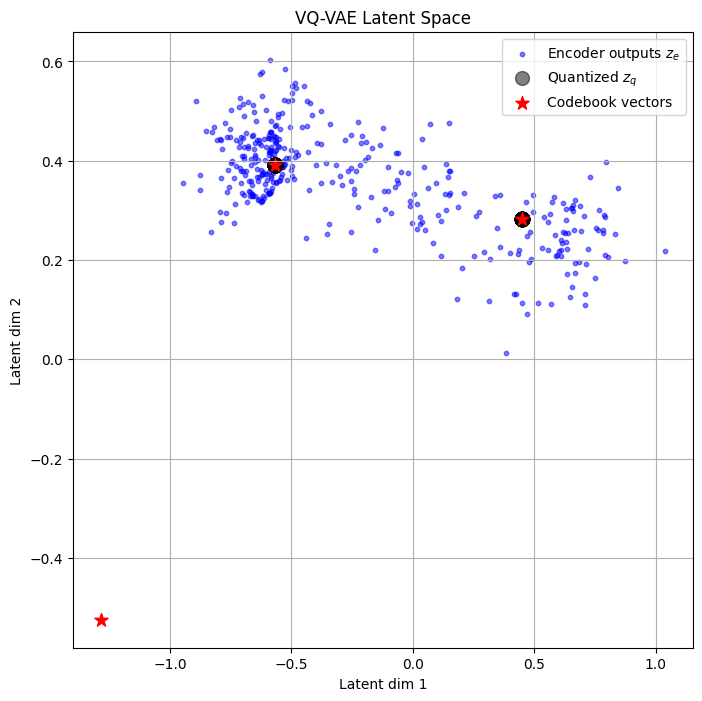

Epoch 1, Loss: 0.0326


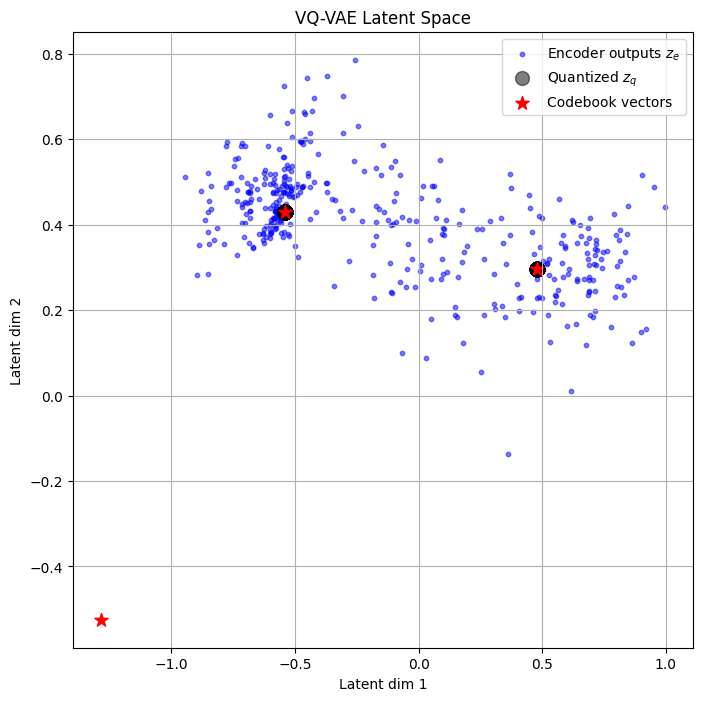

Epoch 2, Loss: 0.0295


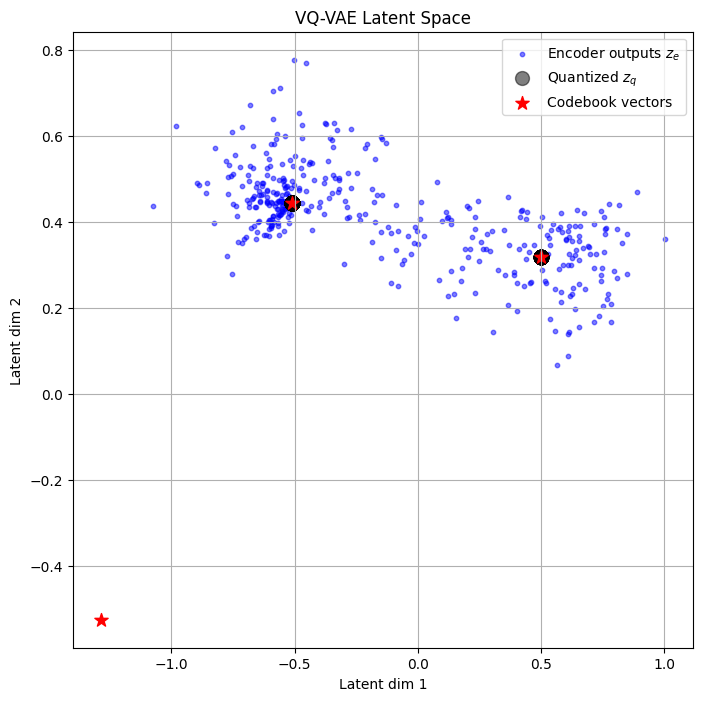

Epoch 3, Loss: 0.0303


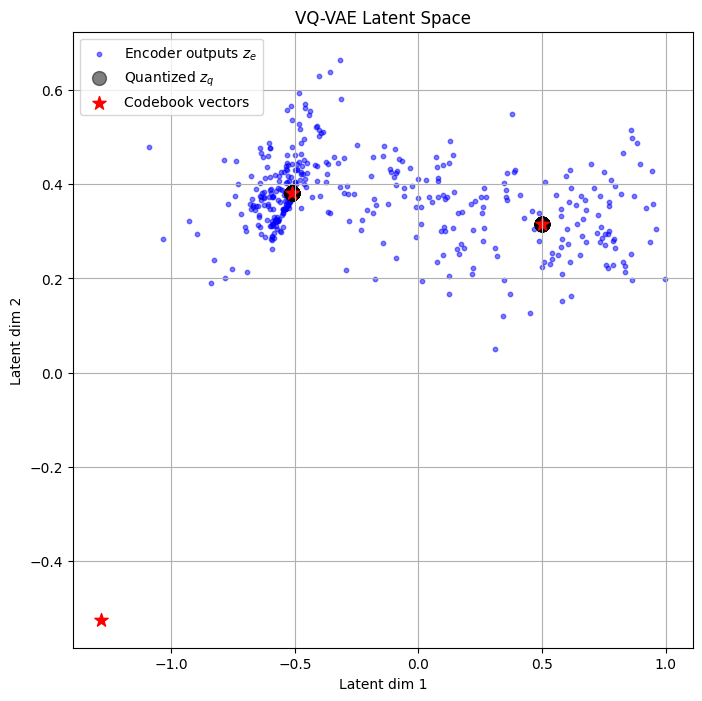

Epoch 4, Loss: 0.0151


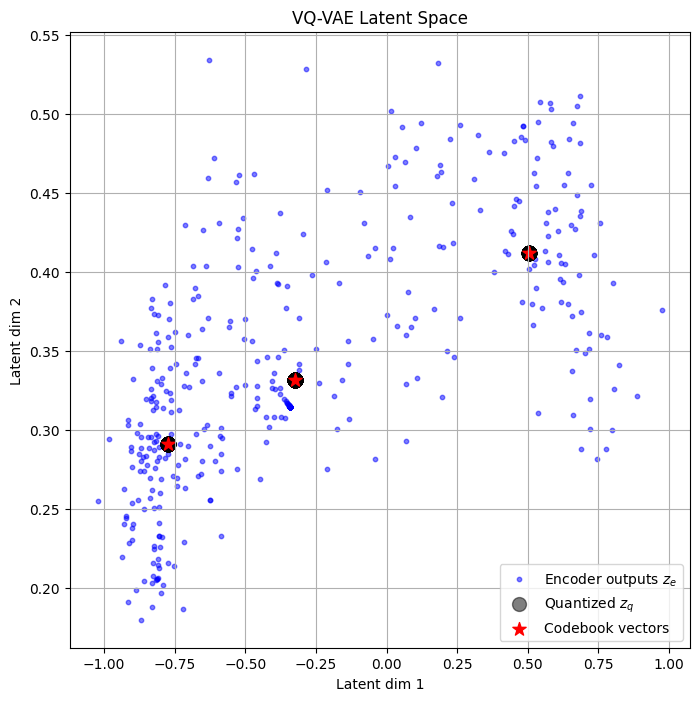

Epoch 5, Loss: 0.0183


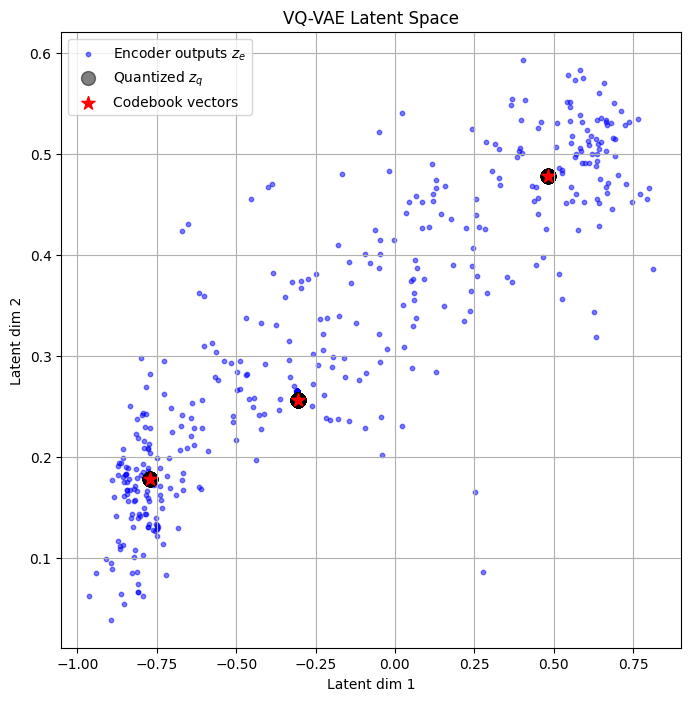

Epoch 6, Loss: 0.0167


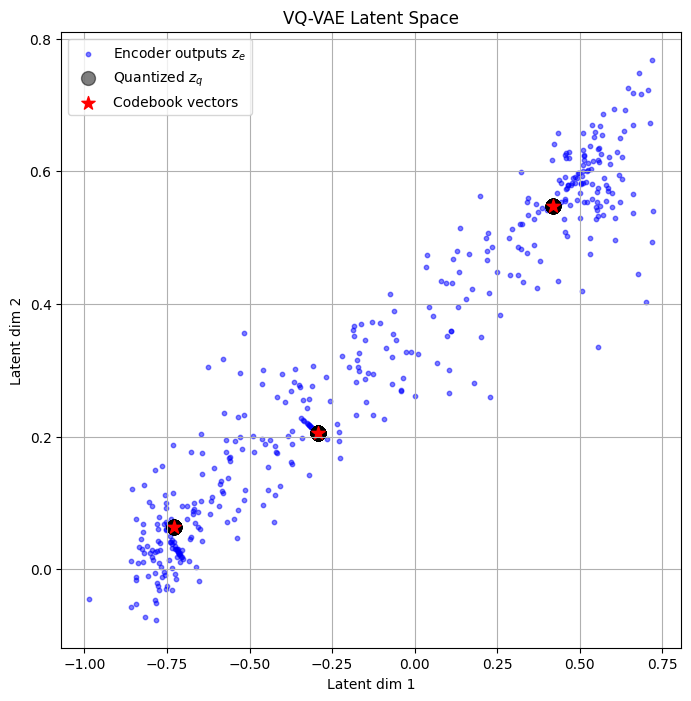

Epoch 7, Loss: 0.0158


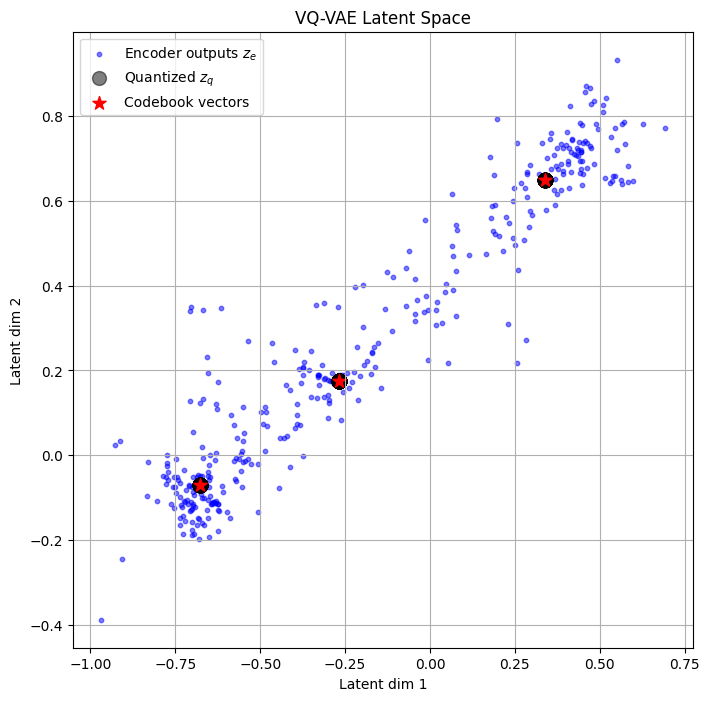

Epoch 8, Loss: 0.0173


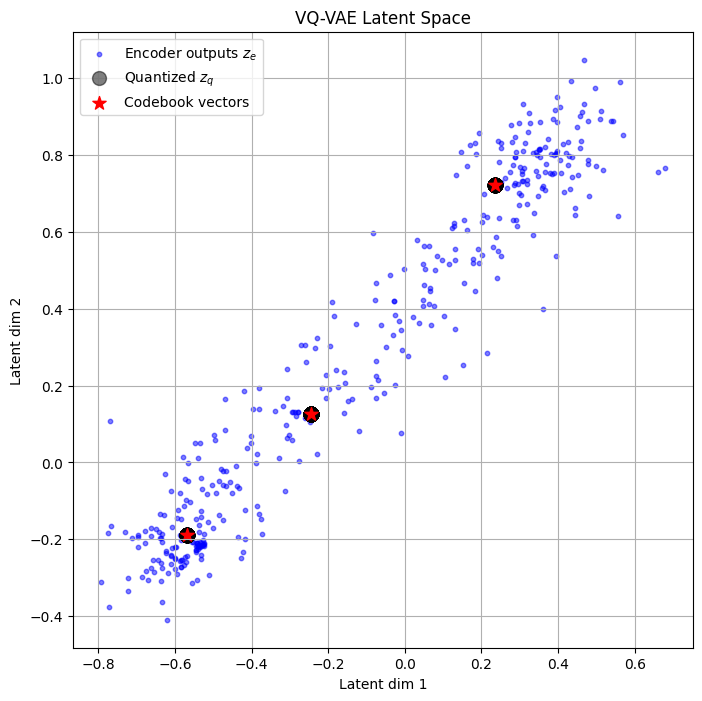

Epoch 9, Loss: 0.0170


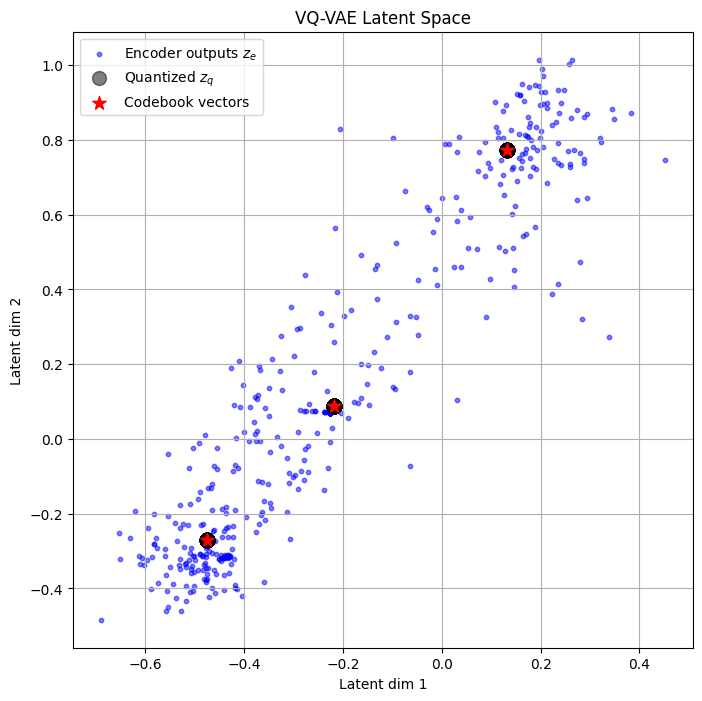

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_loader = DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=32, shuffle=True
)

model = SimpleVQVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(10):
    for x, _ in train_loader:
        x_recon, loss, _, _ = model(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    x, _ = next(iter(train_loader))
    x_recon, loss, z_e, z_q = model(x)
    visualize_latents(z_e, z_q, model.vq.embeddings)



Попытка визуализовать Вектора из кодбука. Они сами по себе трехмерные, поэтому их текстура повторяется несоклько раз, чтоб их можно было записхнуть в декодер и рассмотреть

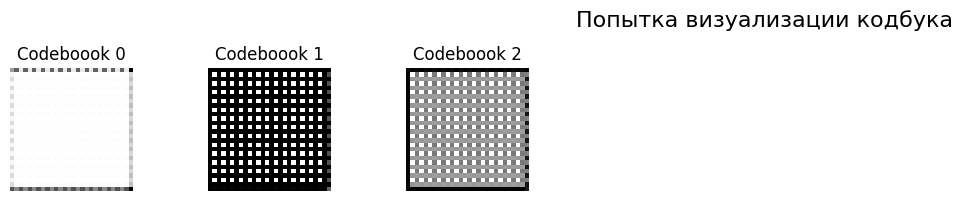

In [ ]:
import matplotlib.pyplot as plt

def visualize_codebook_reconstructions(model, device='cpu'):
    codebook = model.vq.embeddings.detach().to(device)  # (K, D)
    num_codes = codebook.shape[0]
    emb_dim = codebook.shape[1]

    # Делаем батч: каждый вектор -> (1, D, 1, 1)
    latents = codebook.view(num_codes, emb_dim, 1, 1)  # (K, D, 1, 1)

    # Повторяем до нужного spatial размера
    latent_spatial_size = 14  # Размер после энкодера
    latents = latents.expand(-1, -1, latent_spatial_size, latent_spatial_size)  # (K, D, 14, 14)


    with torch.no_grad():
        recons = model.decoder(latents.to(device))  # (K, 1, 28, 28)


    n_cols = 8
    n_rows = (num_codes + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(num_codes):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(recons[i, 0].cpu(), cmap='gray')
        plt.axis('off')
        plt.title(f"Codeboook {i}")
    plt.suptitle("Попытка визуализации кодбука", fontsize=16)
    plt.tight_layout()
    plt.show()
visualize_codebook_reconstructions(model)

Инетересное наблюдение : на двух векторах в кодбуке декодер коллапсирует, а на трех отрабатывает очень даже

Сравним визуально работу декодера

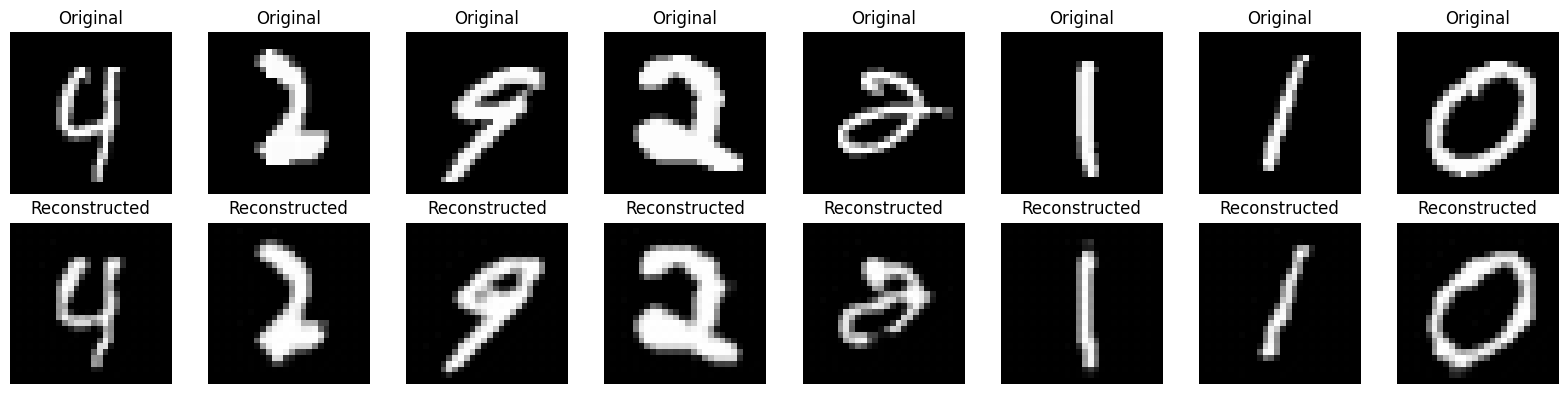

In [ ]:
def show_original_and_reconstructed(model, x, device='cpu'):
    model.eval()
    x = x.to(device)

    with torch.no_grad():
        x_recon, _, _, _ = model(x)

    n = min(8, x.size(0))  # Покажем первые n картинок

    plt.figure(figsize=(n * 2, 4))

    for i in range(n):
        # Оригинал
        plt.subplot(2, n, i + 1)
        plt.imshow(x[i, 0].cpu(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Реконструкция
        plt.subplot(2, n, n + i + 1)
        plt.imshow(x_recon[i, 0].cpu(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
x, _ = next(iter(train_loader))
show_original_and_reconstructed(model, x)


Далее идет Реализация VAE

21.949457360331216 153.58455653889973
33.698390466308595 80.5269919881185
34.32689754740397 76.23873033447266
34.270251731363935 75.23322279663086
33.93359139099121 73.77205658569336


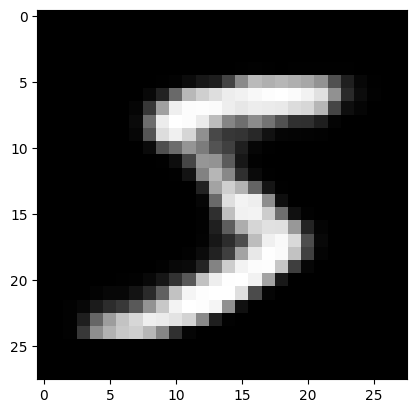

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader


class VAE(nn.Module):
  def __init__(self, input_dim, h_dim, z_dim):
      super().__init__()
      self.img2_hid = nn.Linear(input_dim, h_dim)
      self.hid2_mean = nn.Linear(h_dim, z_dim)
      self.hid2_sigma = nn.Linear(h_dim, z_dim)


      self.z2_hid = nn.Linear(z_dim, h_dim)
      self.hid2_img = nn.Linear(h_dim, input_dim)


  def encode(self, x):
    h = F.relu(self.img2_hid(x))
    mean = self.hid2_mean(h)
    sigma = self.hid2_sigma(h)
    return mean, sigma

  def decode(self, x):
    h = F.relu(self.z2_hid(x))
    return torch.sigmoid(self.hid2_img(h))

  def forward(self, x):
    mean, sigma = self.encode(x)
    eps = torch.randn_like(sigma)
    z_reparametrized = mean + sigma*eps
    x_reconstructed = self.decode(z_reparametrized)
    return x_reconstructed , mean, sigma

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 50
BATCH_SIZE = 32
LR_RATE = 3e-4

dataset = datasets.MNIST(root = 'data/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset = dataset, batch_size=BATCH_SIZE, shuffle=True)

vae = VAE(input_dim=28*28, h_dim=300, z_dim = 20).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr = LR_RATE)

vae.train()


for epoch in range(NUM_EPOCHS):
  total_recon_loss = 0
  total_kl_loss = 0
  for image, label in train_loader:
    optimizer.zero_grad()
    image = image.to(device)
    image = image.view(-1, 28*28)
    x_reconstructed, mean, sigma = vae(image)
    recon_loss = F.binary_cross_entropy(x_reconstructed, image, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mean.pow(2) - sigma.pow(2))
    loss = 2*recon_loss + kl_loss

    loss.backward()

    optimizer.step()
    total_recon_loss += recon_loss.item()
    total_kl_loss += kl_loss.item()
  if epoch % 10 == 0:
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_loss = total_kl_loss / len(train_loader.dataset)
    print(avg_kl_loss, avg_recon_loss)

with torch.inference_mode():
  image, label = dataset[0]
  image = image.to(device)
  image = image.view(-1, 28*28)
  x_reconstructed, mean, sigma = vae(image)
  x_reconstructed = x_reconstructed.cpu().detach().numpy()
  x_reconstructed = x_reconstructed.reshape(28,28)
  plt.imshow(x_reconstructed,cmap = 'gray')
  plt.show()




Посмотрим на работу декодера


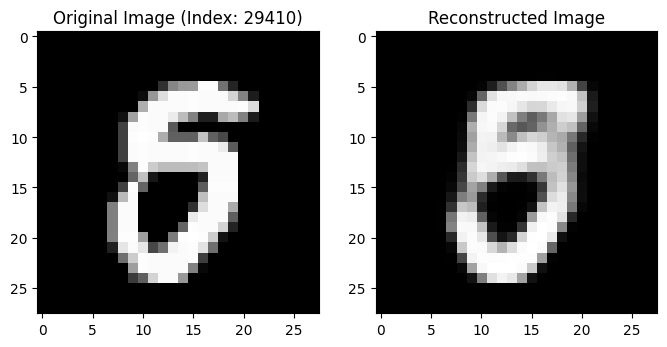

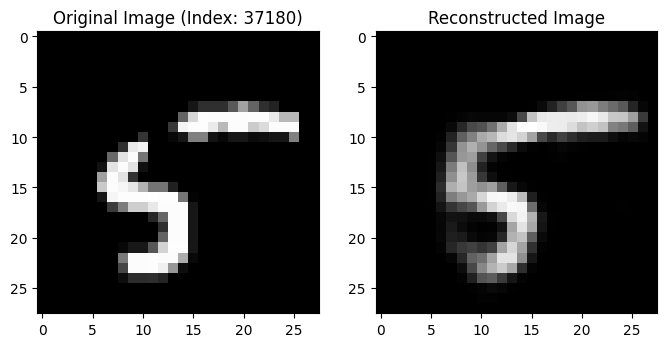

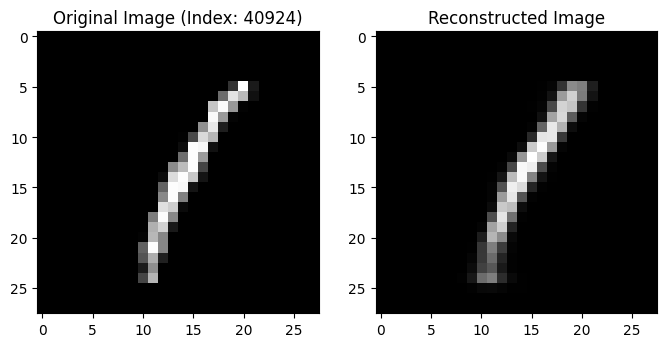

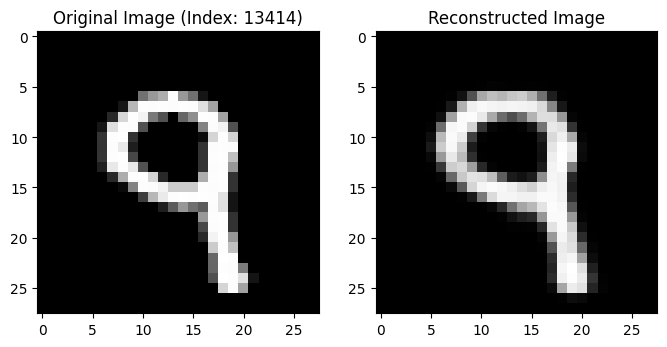

In [ ]:


import random
import matplotlib.pyplot as plt


random_indices = random.sample(range(len(dataset)), 4)

for i in random_indices:
    image, label = dataset[i]
    image = image.to(device)
    image = image.view(-1, 28*28)


    with torch.inference_mode():
        x_reconstructed, mean, sigma = vae(image)
        x_reconstructed = x_reconstructed.cpu().detach().numpy()
        x_reconstructed = x_reconstructed.reshape(28, 28)


    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image.cpu().reshape(28, 28), cmap='gray')
    plt.title(f"Original Image (Index: {i})")

    plt.subplot(1, 2, 2)
    plt.imshow(x_reconstructed, cmap='gray')
    plt.title("Reconstructed Image")

    plt.show()


Основная фишка VAE - непрерывное латентное пространство, возьмем 2 объекта оттуда и плавно пройдемся от одного к другому

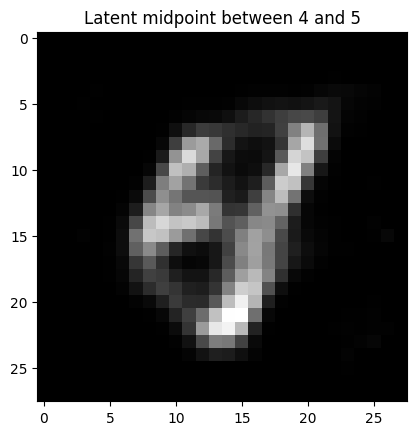

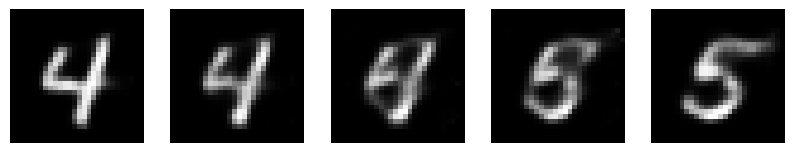

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

dataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)

indices_4 = [i for i, (img, label) in enumerate(dataset) if label == 4]
indices_5 = [i for i, (img, label) in enumerate(dataset) if label == 5]

subset_4 = Subset(dataset, indices_4)
subset_5 = Subset(dataset, indices_5)

loader_4 = DataLoader(subset_4, batch_size=32, shuffle=True)
loader_5 = DataLoader(subset_5, batch_size=32, shuffle=True)

# Возьмём одну партию картинок 4
images_4, _ = next(iter(loader_4))
images_4 = images_4.to(device)
images_4 = images_4.view(-1, 28*28)  # приводим к (batch_size, 784)

# Возьмём одну партию картинок 5
images_5, _ = next(iter(loader_5))
images_5 = images_5.to(device)
images_5 = images_5.view(-1, 28*28)
vae.eval()
with torch.no_grad():
    mean_4, sigma_4 = vae.encode(images_4)
    mean_5, sigma_5 = vae.encode(images_5)

# Возьмём усреднённый вектор по батчу, чтобы получить «типичную» 4 и «типичную» 5
z_4 = mean_4.mean(dim=0)
z_5 = mean_5.mean(dim=0)
z_mid = (z_4 + z_5) / 2


# Например, 5 точек от z_4 до z_5
alphas = np.linspace(0, 1, 5)

z_list = []
for alpha in alphas:
    z_interp = (1 - alpha) * z_4 + alpha * z_5
    z_list.append(z_interp)
with torch.no_grad():
    x_mid = vae.decode(z_mid.unsqueeze(0))   # превращаем (z_dim,) -> (1, z_dim)
    # x_mid: shape (1, 784)
    x_mid = x_mid.view(28, 28)              # восстанавливаем 28x28

# Теперь x_mid — это тензор, который можно вывести через matplotlib

plt.imshow(x_mid.cpu().numpy(), cmap='gray')
plt.title('Latent midpoint between 4 and 5')
plt.show()
decoded_images = []
with torch.no_grad():
    for z in z_list:
        x_decoded = vae.decode(z.unsqueeze(0))
        decoded_images.append(x_decoded.view(28, 28).cpu().numpy())

fig, axs = plt.subplots(1, len(decoded_images), figsize=(10, 2))
for i, img in enumerate(decoded_images):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
plt.show()


Так же возьмем нечто случайное из латентного пространства и посмотрим, похоже ли оно на цифру

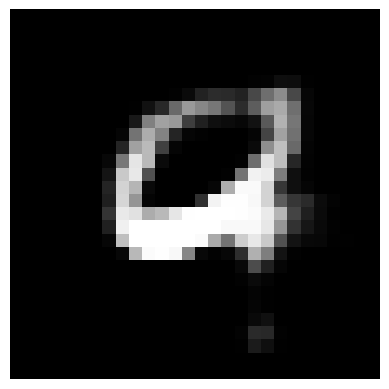

In [ ]:
import torch
import matplotlib.pyplot as plt
torch.manual_seed(27)
z_dim = 20
mean_z = torch.ones(z_dim)

z = torch.normal(mean_z, 1).to(device)


with torch.inference_mode():
    generated = vae.decode(z)


generated = generated.view(28, 28).cpu().numpy()

# 4. Покажем результат
plt.imshow(generated, cmap='gray')
plt.axis('off')
plt.show()
